# Testing the Linear Model trained in TensorFlow 

In [1]:
from __future__ import print_function
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
from math import acos
import numpy as np
import matplotlib.pyplot as plt
from link_bot_notebooks.linear_tf_model import LinearTFModel

importing Jupyter notebook from /home/pmitrano/catkin_ws/src/link_bot/link_bot_notebooks/src/link_bot_notebooks/toy_problem_optimization_common.ipynb


In [2]:
goal = np.array([[0], [0], [1], [0], [2], [0]])
args = {'checkpoint': "log_data/best_linear/November_29_15:23:45__fa0c3e89e594c961f0a5e032b9bf9a511732fd42/nn.ckpt-50000", 'log': False}
dataset = "../../../link_bot_teleop/data/2_link_pos_and_vel_2.txt"
n, x = tpo.load_train(dataset, N=6, L=2, extract_func=tpo.link_pos_vel_extractor2(6))
model = LinearTFModel(args, N=6, M=2, L=2, n_steps=1)
model.load()

INFO:tensorflow:Restoring parameters from log_data/best_linear/November_29_15:23:45__fa0c3e89e594c961f0a5e032b9bf9a511732fd42/nn.ckpt-50000
Restored ckpt log_data/best_linear/November_29_15:23:45__fa0c3e89e594c961f0a5e032b9bf9a511732fd42/nn.ckpt-50000 at step 50000


In [3]:
A, B, C, D, c_loss, sp_loss, cp_loss, reg, loss = model.evaluate(x, goal, display=True)

Cost Loss: 0.00594189064577
State Prediction Loss: 0.000618508725893
Cost Prediction Loss: 0.0139931757003
Regularization: 2.27551293364e-08
Overall Loss: 0.0205535963178
A:
[[ 1.26 -0.91  0.04 -0.   -0.01 -0.  ]
 [-0.77 -0.94 -0.   -0.01 -0.01 -0.  ]]
B:
[[-0.    0.  ]
 [-0.    0.01]]
C:
[[ 0.07  0.01]
 [-0.01 -0.03]]
D:
[[ 0.41 -0.1 ]
 [ 0.16  0.67]]


In [4]:
data = tpo.load_data(dataset, g=goal, extract_func=tpo.two_link_pos_vel_extractor)

In [5]:
def cost_at_xy(x, y):
    s = np.array([[x], [y], [x], [y], [x], [y]])
    print(model.cost_of_s(s, goal)[0,0])
    
cost_at_xy(5, 5)
cost_at_xy(-5, 5)
cost_at_xy(-5, -5)
cost_at_xy(5, -5)

50.043415
50.54555
50.35289
50.400585


In [6]:
# set_d = model.D.assign(np.eye(2))
# _ = model.sess.run(set_d)

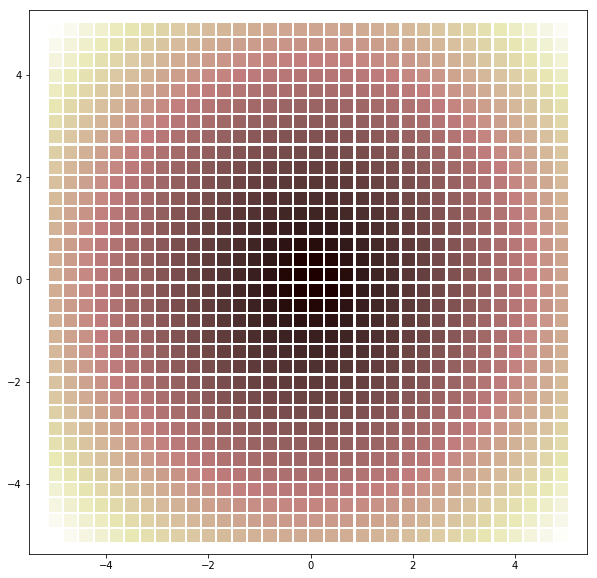

In [7]:
tpo.plot_costmap_2(plt, model, data, goal, resolution=.3, minimum=-5, maximum=5);

In [8]:
cost_at_xy(5, 5)
cost_at_xy(-5, 5)
cost_at_xy(-5, -5)
cost_at_xy(5, -5)

50.043415
50.54555
50.35289
50.400585


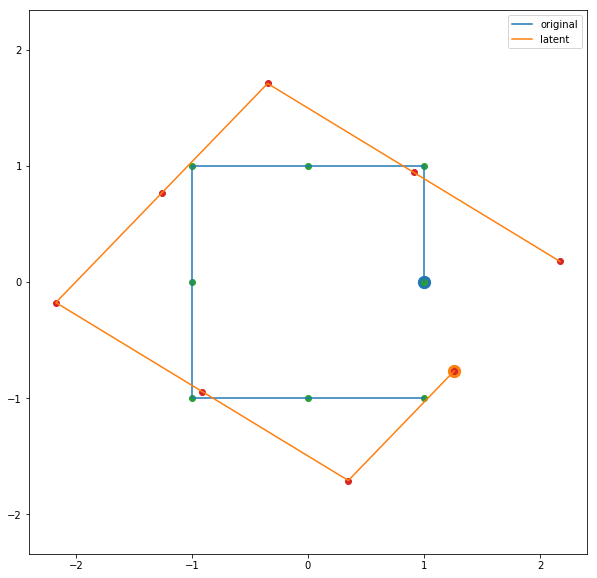

In [9]:
points = np.array([[1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])
R = model.get_A()[:,:2]
new_points = []
for p in points:
    new_p = np.dot(R, p)
    new_points.append(new_p)
new_points = np.array(new_points)
    
plt.figure(figsize=(10,10))
plt.scatter([points[0,0]], [points[0,1]], s=150)
plt.scatter([new_points[0,0]], [new_points[0,1]], s=150)
plt.scatter([p[0] for p in points], [p[1] for p in points])
plt.scatter([p[0] for p in new_points], [p[1] for p in new_points])
plt.plot([p[0] for p in points], [p[1] for p in points], label='original')
plt.plot([p[0] for p in new_points], [p[1] for p in new_points], label='latent')
plt.legend()
plt.axis("equal");

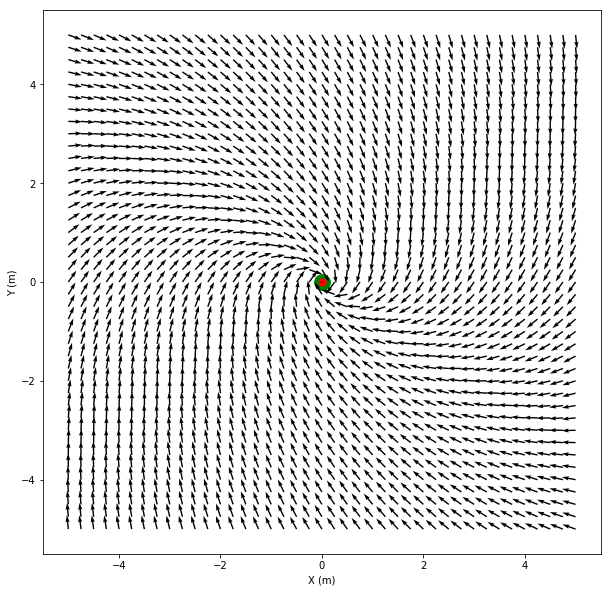

In [10]:
r = 0.25
cx = 0
cy = 0
m = 5
x = []
y = []
u = []
v = []
goal = np.array([[cx], [cy], [0], [0], [0], [0]])
min_a = 1e9 * np.ones((2, 1))
min_a_x = None
min_a_y = None
MAX_SPEED=1
og = model.reduce(goal)
for s1 in np.arange(cx-m, cx+m+r, r):
    for s2 in np.arange(cy-m, cy+m+r, r):
        o = model.reduce(np.array([[s1], [s2], [0], [0], [0], [0]]))
        o1 = o[0, 0]
        o2 = o[1, 0]
        full_a, full_c, next_o = model.act(o, goal)
        if np.linalg.norm(full_a) > MAX_SPEED:
            a = full_a / np.linalg.norm(full_a) * MAX_SPEED  # a is in meters per second. Cap to 0.75
        else:
            a = full_a

        x.append(s1)
        y.append(s2)
        u.append(a[0, 0, 0])
        v.append(a[0, 1, 0])
        if np.linalg.norm(full_a) < np.linalg.norm(min_a):
            min_a = a
            min_a_x = s1
            min_a_y = s2
        
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.scatter(goal[0, 0], goal[1, 0], s=250, c='g')
ax.scatter(min_a_x, min_a_y, s=50, c='r')
q = ax.quiver(x, y, u, v, scale=40, width=0.0025)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)");

In [11]:
x = 2
y = -2
o = model.reduce(np.array([[x], [y], [0], [0], [0], [0]]))
o1 = o[0, 0]
o2 = o[1, 0]
u, _, _ = model.act(o, goal)
u = u / np.linalg.norm(u)
print("Newton Step:", u[0].T)
print("Newton Step Cost:", model.predict_cost(o, u, goal)[0,0])
min_cost = 1e9
min_cost_u = None
for angle in np.linspace(-np.pi, np.pi, 100):
    u = np.array([[[np.cos(angle)], [np.sin(angle)]]])
    cost = model.predict_cost(o, u, goal)[0, 0]
    if cost < min_cost:
        min_cost = cost
        min_cost_u = u;
print("Steepest-Descent: ", min_cost_u[0].T)
print("Steepest-Descent Cost: ", min_cost)

Newton Step: [[-0.94  0.33]]
Newton Step Cost: 7.6397
Steepest-Descent:  [[-0.99 -0.13]]
Steepest-Descent Cost:  7.61799
